In [11]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import re, time
import matplotlib.pyplot as plt

In [12]:
pd.options.display.max_rows = 20

In [13]:
url = "https://berlin.kauperts.de/Strassenverzeichnis"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "html.parser")

In [14]:
web_download = []
for x in soup.find_all("a", href = True):
    web_download.append(x["href"])

In [15]:
berlin = pd.DataFrame(pd.Series(web_download[37:-14]).str.split("/").str[4], columns = ["Neighborhood"])
berlin.head(10)

,Neighborhood
0,NaN
1,Charlottenburg
2,Charlottenburg-Nord
3,Grunewald
4,Halensee
5,Schmargendorf
6,Westend
7,Wilmersdorf
8,NaN
9,Friedrichshain


In [16]:
neighborhood_borough = []

for x in range(len(berlin)):
    neighborhood_borough.append(berlin.iloc[0:x, 0].isna().sum() - 1)

neighborhood_borough = neighborhood_borough[1:]
neighborhood_borough.append(berlin.iloc[0:x, 0].isna().sum() - 1)

neighborhood_borough[0:5]

[0, 0, 0, 0, 0]

In [17]:
berlin["borough_index"] = neighborhood_borough
berlin.head()

,Neighborhood,borough_index
0,NaN,0
1,Charlottenburg,0
2,Charlottenburg-Nord,0
3,Grunewald,0
4,Halensee,0


In [18]:
borough = pd.DataFrame(soup.find_all("a", class_ = "district-name"), columns = ["Borough"])["Borough"].to_dict()
borough[4] = "Berlin-Mitte"
borough

{0: 'Charlottenburg-Wilmersdorf',
 1: 'Friedrichshain-Kreuzberg',
 2: 'Lichtenberg',
 3: 'Marzahn-Hellersdorf',
 4: 'Berlin-Mitte',
 5: 'Neukölln',
 6: 'Pankow',
 7: 'Reinickendorf',
 8: 'Spandau',
 9: 'Steglitz-Zehlendorf',
 10: 'Tempelhof-Schöneberg',
 11: 'Treptow-Köpenick'}

In [19]:
berlin["Borough"] = berlin["borough_index"].map(borough)
berlin.drop(columns = "borough_index", inplace = True)
berlin = berlin.loc[berlin["Neighborhood"].notna(), :].reset_index(drop = True)
berlin

,Neighborhood,Borough
0,Charlottenburg,Charlottenburg-Wilmersdorf
1,Charlottenburg-Nord,Charlottenburg-Wilmersdorf
2,Grunewald,Charlottenburg-Wilmersdorf
3,Halensee,Charlottenburg-Wilmersdorf
4,Schmargendorf,Charlottenburg-Wilmersdorf
...,...,...
91,Niederschoeneweide,Treptow-Köpenick
92,Oberschoeneweide,Treptow-Köpenick
93,Plaenterwald,Treptow-Köpenick
94,Rahnsdorf,Treptow-Köpenick


In [20]:
prices = pd.read_csv("price_berlin.csv", usecols = [0, 10]).rename(columns = {"Bezirk": "Borough", "Q1 2019": "Price"})
prices["Price"] = (prices["Price"] * 1000).astype(int)
prices.loc[prices["Borough"] == "Mitte", "Borough"] = "Berlin-Mitte"
prices.head(12)

,Borough,Price
0,Charlottenburg-Wilmersdorf,4856
1,Berlin-Mitte,4693
2,Friedrichshain-Kreuzberg,4555
3,Pankow,4467
4,Steglitz-Zehlendorf,4068
5,Tempelhof-Schöneberg,4031
6,Neukölln,3758
7,Lichtenberg,3585
8,Reinickendorf,3053
9,Treptow-Köpenick,3013


In [23]:
url = "https://www.citypopulation.de/de/germany/berlin/admin/"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "html")

In [24]:
soup1 = soup.find_all(itemprop="name")[3:]
del soup1[57]
soup2 = soup.find_all(class_="rpop prio1")[1:-1]

In [25]:
people = pd.merge(pd.DataFrame(soup1), pd.DataFrame(soup2), left_index = True, right_index = True)
people.columns = ["Borough", "People"]
people["People"] = people["People"].replace("\.", "", regex = True).astype(int)
people["Borough"] = people["Borough"].str.replace(" ", "")
people.sort_values("People", ascending = False, inplace = True)
people.drop_duplicates(subset = "Borough", keep = "first", inplace = True)
people["isin"] = people["Borough"].isin(prices["Borough"])
people = people.loc[people["isin"] == True, ["Borough", "People"]].reset_index(drop = True)
people

,Borough,People
0,Pankow,409335
1,Berlin-Mitte,385748
2,Tempelhof-Schöneberg,350984
3,Charlottenburg-Wilmersdorf,343592
4,Neukölln,329917
5,Steglitz-Zehlendorf,310071
6,Lichtenberg,294201
7,Friedrichshain-Kreuzberg,290386
8,Treptow-Köpenick,273689
9,Marzahn-Hellersdorf,269967


In [26]:
berlin_borough = pd.merge(prices, people, on = "Borough", how = "left")
berlin_borough

,Borough,Price,People
0,Charlottenburg-Wilmersdorf,4856,343592
1,Berlin-Mitte,4693,385748
2,Friedrichshain-Kreuzberg,4555,290386
3,Pankow,4467,409335
4,Steglitz-Zehlendorf,4068,310071
5,Tempelhof-Schöneberg,4031,350984
6,Neukölln,3758,329917
7,Lichtenberg,3585,294201
8,Reinickendorf,3053,266408
9,Treptow-Köpenick,3013,273689


In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()

In [29]:
def scale(series):
    X = np.array(series).reshape(-1, 1)
    scaler.fit(X)
    column = scaler.transform(X)

    return(column)

In [30]:
berlin_borough["Price_Scaled"] = scale(berlin_borough["Price"]).round(2)
berlin_borough["People_Scaled"] = scale(berlin_borough["People"]).round(2)

In [31]:
berlin_borough

,Borough,Price,People,Price_Scaled,People_Scaled
0,Charlottenburg-Wilmersdorf,4856,343592,1.41,0.61
1,Berlin-Mitte,4693,385748,1.19,1.48
2,Friedrichshain-Kreuzberg,4555,290386,1.01,-0.49
3,Pankow,4467,409335,0.90,1.96
4,Steglitz-Zehlendorf,4068,310071,0.38,-0.08
5,Tempelhof-Schöneberg,4031,350984,0.33,0.76
6,Neukölln,3758,329917,-0.03,0.33
7,Lichtenberg,3585,294201,-0.25,-0.41
8,Reinickendorf,3053,266408,-0.94,-0.98
9,Treptow-Köpenick,3013,273689,-1.00,-0.83


In [32]:
import seaborn as sns

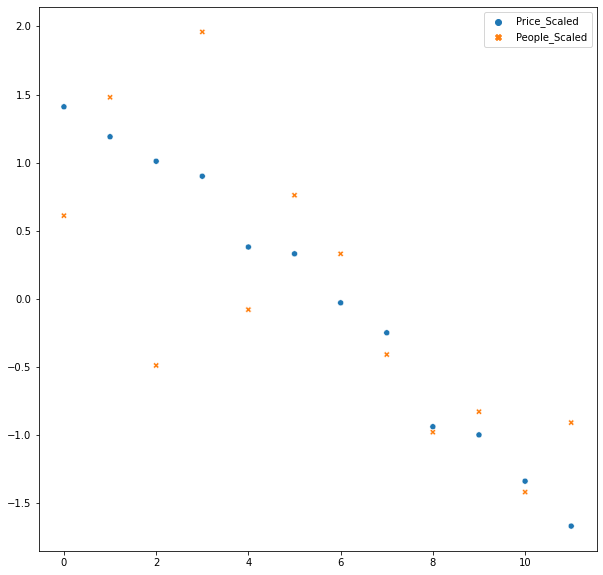

In [33]:
plt.figure(figsize = (10, 10))
scatter = sns.scatterplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]])

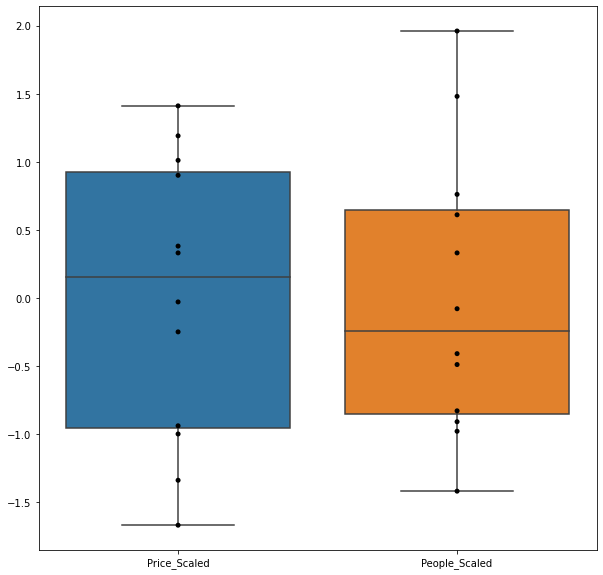

In [34]:
plt.figure(figsize = (10, 10))
bp = sns.boxplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]])
bp = sns.swarmplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]], color = "0.0")

In [35]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

In [36]:
geolocator = Nominatim(user_agent = "coursera_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1.1)

latitude_list = []
longitude_list = []

for neighborhood in range(len(berlin)):
    location = geolocator.geocode(berlin.iloc[neighborhood, 0] + " ,Berlin", timeout = 10)
    if location == None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)

latitude = pd.Series(latitude_list)
longitude = pd.Series(longitude_list)

In [37]:
print(latitude.isna().sum())
print(longitude.isna().sum())

0
0


In [38]:
berlin["Latitude"] = latitude.values
berlin["Longitude"] = longitude.values
berlin.head()

,Neighborhood,Borough,Latitude,Longitude
0,Charlottenburg,Charlottenburg-Wilmersdorf,52.515747,13.309683
1,Charlottenburg-Nord,Charlottenburg-Wilmersdorf,52.540525,13.296266
2,Grunewald,Charlottenburg-Wilmersdorf,52.460482,13.238699
3,Halensee,Charlottenburg-Wilmersdorf,52.497226,13.292999
4,Schmargendorf,Charlottenburg-Wilmersdorf,52.478902,13.292996


In [39]:
def get_coordinates(place):
    address_place = place
    location = geolocator.geocode(address_place, timeout = 10)
    latitude = location.latitude
    longitude = location.longitude
    return(latitude, longitude)

In [40]:
import folium
from folium import plugins

In [41]:
map_berlin = folium.Map(location = [get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start = 10)

markers = plugins.MarkerCluster().add_to(map_berlin)

for lat, lng, borough, neighborhood in zip(berlin['Latitude'], berlin['Longitude'], berlin["Borough"], berlin["Neighborhood"]):
    folium.Marker(
        location = [lat, lng],
        popup = "{}, {}".format(borough, neighborhood)
    ).add_to(markers)

map_berlin

In [42]:
import requests
from pandas.io.json import json_normalize

In [43]:
CLIENT_ID = '3WBEZJF1MOQYJPJIPHJ2R5CSORYSCFCWO2HWBE55DJJNYCLU' # your Foursquare ID
CLIENT_SECRET = 'RL51MYTZRN40LR5SX4F4WDTMTGVIEVZGDAFK0KNO5HWFF1QB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

    return(nearby_venues)

In [45]:
berlin_venues = getNearbyVenues(berlin["Neighborhood"], berlin["Latitude"], berlin["Longitude"])

Charlottenburg
Charlottenburg-Nord
Grunewald
Halensee
Schmargendorf
Westend
Wilmersdorf
Friedrichshain
Kreuzberg
Alt-Hohenschoenhausen
Falkenberg
Fennpfuhl
Friedrichsfelde
Karlshorst
Lichtenberg
Malchow
Neu-Hohenschoenhausen
Rummelsburg
Wartenberg
Biesdorf
Hellersdorf
Kaulsdorf
Mahlsdorf
Marzahn
Gesundbrunnen
Hansaviertel
Mitte
Moabit
Tiergarten
Wedding
Britz
Buckow
Gropiusstadt
Neukoelln
Rudow
Blankenburg
Blankenfelde
Buch
Franzoesisch-Buchholz
Heinersdorf
Karow
Niederschoenhausen
Pankow
Prenzlauer-Berg
Rosenthal
Stadtrandsiedlung-Malchow
Weissensee
Wilhelmsruh
Borsigwalde
Frohnau
Heiligensee
Hermsdorf
Konradshoehe
Luebars
Maerkisches-Viertel
Reinickendorf
Tegel
Waidmannslust
Wittenau
Falkenhagener-Feld
Gatow
Hakenfelde
Haselhorst
Kladow
Siemensstadt
Spandau
Staaken
Wilhelmstadt
Dahlem
Lankwitz
Lichterfelde
Nikolassee
Steglitz
Wannsee
Zehlendorf
Friedenau
Lichtenrade
Mariendorf
Marienfelde
Schoeneberg
Tempelhof
Adlershof
Alt-Treptow
Altglienicke
Baumschulenweg
Bohnsdorf
Friedrichshage

In [46]:
berlin_venues = pd.merge(berlin_venues, berlin[["Neighborhood", "Borough"]], on = "Neighborhood", how = "left")
print(berlin_venues.shape)
berlin_venues.head()

(1455, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,Charlottenburg,52.515747,13.309683,Trattoria Rathaus Piazza,52.516778,13.308748,Trattoria/Osteria,Charlottenburg-Wilmersdorf
1,Charlottenburg,52.515747,13.309683,Zur Mieze - Katzenmusikcafé,52.515899,13.304765,Pet Café,Charlottenburg-Wilmersdorf
2,Charlottenburg,52.515747,13.309683,Deutsche Oper Berlin,52.512088,13.308354,Opera House,Charlottenburg-Wilmersdorf
3,Charlottenburg,52.515747,13.309683,Postbank Finanzcenter,52.515821,13.312408,Bank,Charlottenburg-Wilmersdorf
4,Charlottenburg,52.515747,13.309683,Rogacki,52.512839,13.305050,Gourmet Shop,Charlottenburg-Wilmersdorf


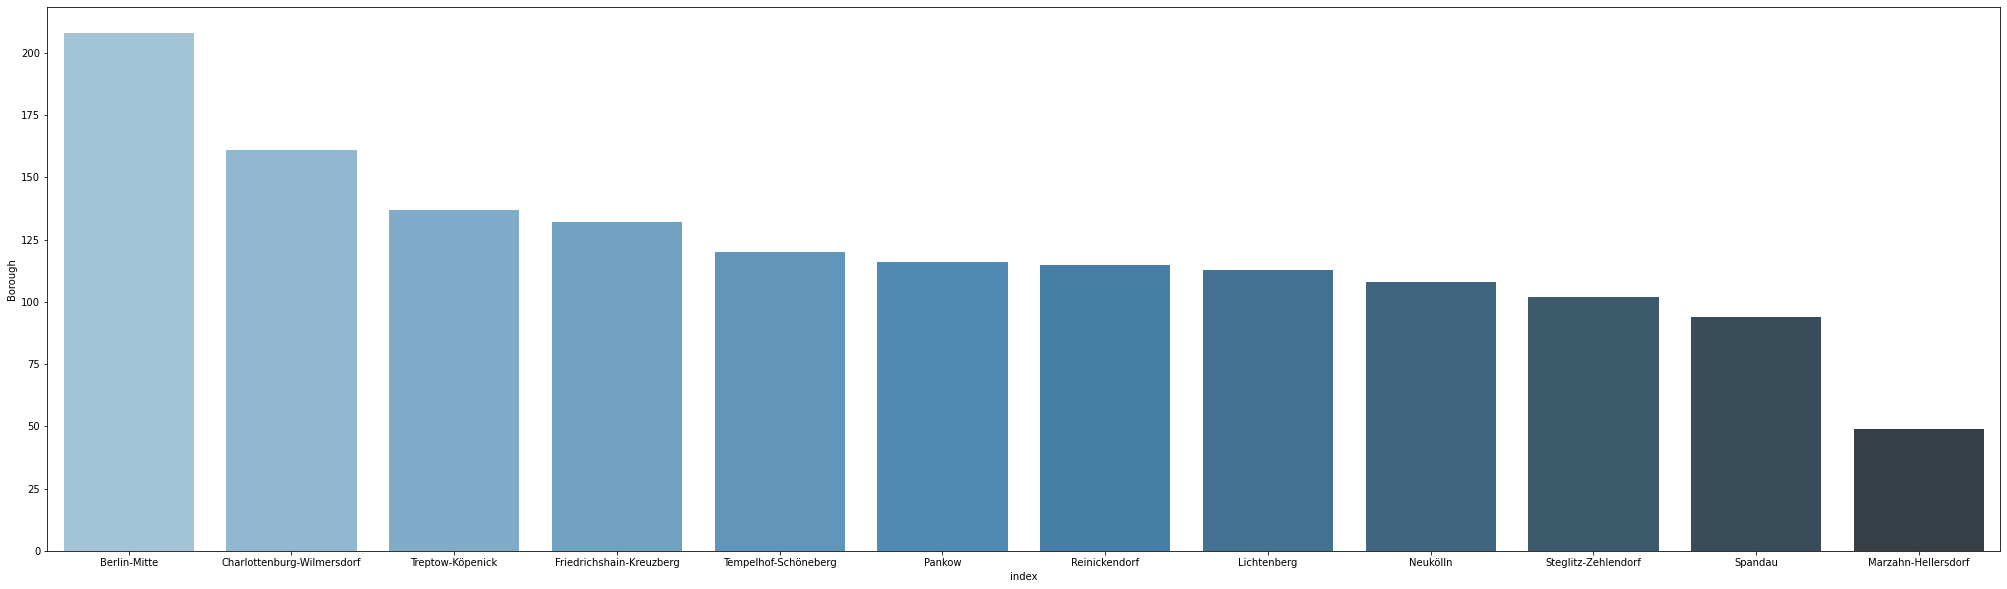

In [47]:
plt.figure(figsize = (35, 10))
bar = sns.barplot(x = "index", y = "Borough", data = pd.DataFrame(berlin_venues["Borough"].value_counts()).reset_index(), palette = "Blues_d")

In [48]:
berlin_venues[["Neighborhood", "Venue", "Venue Category"]].groupby(["Neighborhood", "Venue Category"]).count()

Venue
Neighborhood Venue Category           
Adlershof    Drugstore               1
             Greek Restaurant        1
             Italian Restaurant      1
             Steakhouse              1
             Supermarket             1
...                                ...
Zehlendorf   Pizza Place             1
             Steakhouse              1
             Supermarket             1
             Tree                    1
             Yoga Studio             1

[1116 rows x 1 columns]

In [49]:
berlin_venues[["Neighborhood", "Venue"]].groupby("Neighborhood").count()

,Venue
Neighborhood,
Adlershof,7
Alt-Hohenschoenhausen,9
Alt-Treptow,28
Altglienicke,1
Baumschulenweg,5
...,...
Wilhelmsruh,14
Wilhelmstadt,11
Wilmersdorf,47


In [50]:
print("There are {} unique categories in Berlin.".format(len(berlin_venues["Venue Category"].unique())))

There are 243 unique categories in Berlin.


In [51]:
berlin_venues[["Borough", "Venue", "Venue Category"]].groupby(["Borough", "Venue Category"]).count()

Venue
Borough          Venue Category              
Berlin-Mitte     Art Gallery                3
                 Art Museum                 3
                 Austrian Restaurant        1
                 BBQ Joint                  1
                 Bakery                     2
...                                       ...
Treptow-Köpenick Taverna                    1
                 Tram Station               4
                 Trattoria/Osteria          2
                 Turkish Restaurant         1
                 Vietnamese Restaurant      1

[740 rows x 1 columns]

In [52]:
berlin_venues["Venue Category"] = berlin_venues["Venue Category"].str.replace("Neighborhood", "Neighborhoods")

In [53]:
berlin_onehot = pd.get_dummies(berlin_venues[["Venue Category"]], prefix = "", prefix_sep = "")

berlin_onehot["Neighborhood"] = berlin_venues["Neighborhood"]

fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

print(berlin_onehot.shape)
berlin_onehot.head()

(1455, 244)


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
berlin_grouped = berlin_onehot.groupby("Neighborhood").mean().reset_index()
print(berlin_grouped.shape)
berlin_grouped

(94, 244)


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alt-Hohenschoenhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Alt-Treptow,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,...,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Altglienicke,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Baumschulenweg,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Wilhelmsruh,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
90,Wilhelmstadt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
91,Wilmersdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,...,0.0,0.042553,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
92,Wittenau,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [55]:
num_top_venues = 5

for hood in berlin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlershof----
                venue  freq
0           Drugstore  0.14
1    Greek Restaurant  0.14
2  Italian Restaurant  0.14
3          Steakhouse  0.14
4        Tram Station  0.14


----Alt-Hohenschoenhausen----
               venue  freq
0  Indian Restaurant  0.11
1        Supermarket  0.11
2   Greek Restaurant  0.11
3       Tram Station  0.11
4        Coffee Shop  0.11


----Alt-Treptow----
                venue  freq
0              Bakery  0.07
1            Platform  0.07
2  Italian Restaurant  0.07
3       Garden Center  0.04
4    Tapas Restaurant  0.04


----Altglienicke----
                  venue  freq
0          Home Service   1.0
1                   ATM   0.0
2  Pakistani Restaurant   0.0
3             Multiplex   0.0
4                Museum   0.0


----Baumschulenweg----
              venue  freq
0       Supermarket   0.4
1    Ice Cream Shop   0.2
2  Asian Restaurant   0.2
3         Drugstore   0.2
4               ATM   0.0


----Biesdorf----
                venue  freq

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Drugstore,Steakhouse,Tram Station,Trattoria/Osteria,Supermarket,Italian Restaurant,Greek Restaurant,Fast Food Restaurant,Fish & Chips Shop,Farmers Market
1,Alt-Hohenschoenhausen,Indian Restaurant,Coffee Shop,Big Box Store,Supermarket,Drugstore,Tram Station,Discount Store,Post Office,Greek Restaurant,Dessert Shop
2,Alt-Treptow,Bakery,Italian Restaurant,Platform,Snack Place,Nightclub,Juice Bar,Tapas Restaurant,Seafood Restaurant,Electronics Store,Playground
3,Altglienicke,Home Service,Zoo Exhibit,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,Baumschulenweg,Supermarket,Ice Cream Shop,Drugstore,Asian Restaurant,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...
89,Wilhelmsruh,Bakery,Bus Stop,Italian Restaurant,Café,Clothing Store,Post Office,Concert Hall,Turkish Restaurant,Lake,Asian Restaurant
90,Wilhelmstadt,Bus Stop,Harbor / Marina,Boat or Ferry,Bakery,Supermarket,Park,Lake,Sporting Goods Shop,Fish Market,Flower Shop
91,Wilmersdorf,Bakery,Italian Restaurant,Supermarket,Hotel,Ice Cream Shop,Burger Joint,Vietnamese Restaurant,French Restaurant,Coffee Shop,Doner Restaurant
92,Wittenau,Church,Park,German Restaurant,Restaurant,Concert Hall,Italian Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Service,Event Space


In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors#
from matplotlib import pyplot as plt

In [59]:
berlin_grouped_clustering = berlin_grouped.drop("Neighborhood", 1)

In [60]:
sil = []
kmax = 20

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(berlin_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(berlin_grouped_clustering, labels, metric = "euclidean"))

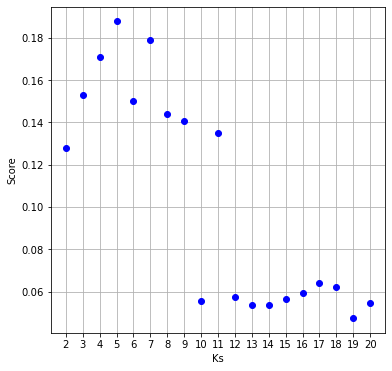

Best value for k with a score of 0.1876798432523653 is 5.


In [61]:
plt.figure(figsize = (6, 6))
line = np.array(sil)
plt.xlabel("Ks")
plt.ylabel("Score")
plt.plot(line, "ro", color = "b", linewidth = 1.0)
plt.grid()
plt.xticks(np.arange(len(line)), np.arange(2, len(line) + 2))
plt.show()
print("Best value for k with a score of {} is {}.".format(max(sil),sil.index(max(sil)) + 2))

In [62]:
k_opt = sil.index(max(sil)) + 2
kclusters = k_opt
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(berlin_grouped_clustering)
kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 1, 1, 1, 1, 1])

In [63]:
neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_)

In [64]:
berlin_merged = berlin.join(neighborhoods_venues_sorted.set_index("Neighborhood"), on = "Neighborhood")
berlin_merged = pd.merge(berlin_merged, berlin_borough, on = "Borough", how = "left")
berlin_merged_columns = list(berlin_merged.columns[:2]) + list(berlin_merged.columns[-4:]) + list(berlin_merged.columns[2:-4])
berlin_merged = berlin_merged[berlin_merged_columns]

In [65]:
berlin_merged.loc[berlin_merged["Cluster Labels"].isna(), :]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Grunewald,Charlottenburg-Wilmersdorf,4856,343592,1.41,0.61,52.460482,13.238699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,Rahnsdorf,Treptow-Köpenick,3013,273689,-1.00,-0.83,52.435873,13.701802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
berlin_merged = berlin_merged.loc[berlin_merged["Cluster Labels"].notna(), :]
berlin_merged.reset_index(drop = True, inplace = True)
berlin_merged["Cluster Labels"] = berlin_merged["Cluster Labels"].astype(int)

In [67]:
map_clusters = folium.Map(location=[get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, borough, cluster, price, people in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged["Borough"], berlin_merged['Cluster Labels'], berlin_merged["Price_Scaled"], berlin_merged["People_Scaled"]):
    label = "{}, {}, {}, {}, {}".format(neigh, borough, cluster ,price, people),
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [68]:
berlin_merged["Cluster Labels"].value_counts()

1    74
0    16
4     2
3     1
2     1
Name: Cluster Labels, dtype: int64

In [69]:
berlin_merged.loc[(berlin_merged["Cluster Labels"] == 1) | (berlin_merged["Cluster Labels"] == 0), :].sort_values("Price", ascending = True)[:15]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Biesdorf,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.510992,13.555013,1,Bakery,Big Box Store,Miscellaneous Shop,Light Rail Station,Palace,Park,Plaza,Fish Market,Fish & Chips Shop,Event Service
20,Kaulsdorf,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.510132,13.580990,0,Supermarket,Hotel,Park,Light Rail Station,Plaza,Event Service,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant
21,Mahlsdorf,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.508699,13.613162,1,Platform,Automotive Shop,Tram Station,Motorcycle Shop,Gym / Fitness Center,IT Services,Light Rail Station,Supermarket,Cosmetics Shop,Furniture / Home Store
22,Marzahn,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.542948,13.563142,1,Windmill,German Restaurant,Tram Station,Gas Station,Asian Restaurant,Liquor Store,Zoo Exhibit,Farm,Event Space,Falafel Restaurant
19,Hellersdorf,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.536854,13.604774,1,Tram Station,Indian Restaurant,Climbing Gym,Drugstore,Electronics Store,Sandwich Place,Multiplex,Shoe Store,Shopping Mall,Big Box Store
58,Falkenhagener-Feld,Spandau,2751,245197,-1.34,-1.42,52.552403,13.166894,0,Supermarket,Snack Place,Drugstore,Chinese Restaurant,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop
66,Wilhelmstadt,Spandau,2751,245197,-1.34,-1.42,52.513921,13.191452,1,Bus Stop,Harbor / Marina,Boat or Ferry,Bakery,Supermarket,Park,Lake,Sporting Goods Shop,Fish Market,Flower Shop
61,Haselhorst,Spandau,2751,245197,-1.34,-1.42,52.541323,13.231156,1,Supermarket,Furniture / Home Store,Metro Station,Bus Stop,Park,BBQ Joint,Automotive Shop,Fish & Chips Shop,Farm,Farmers Market
62,Kladow,Spandau,2751,245197,-1.34,-1.42,52.460293,13.140052,1,Bakery,Flower Shop,Zoo Exhibit,Fountain,Food Court,Food & Drink Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
63,Siemensstadt,Spandau,2751,245197,-1.34,-1.42,52.539808,13.256893,1,Furniture / Home Store,Hotel Bar,Auto Dealership,Restaurant,Baby Store,Event Space,Historic Site,Playground,Hotel,Sandwich Place


In [70]:
berlin_merged.loc[(berlin_merged["Cluster Labels"] == 1) | (berlin_merged["Cluster Labels"] == 0), :].sort_values("Price", ascending = True)[-15:]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Wilhelmsruh,Pankow,4467,409335,0.90,1.96,52.588012,13.362206,1,Bakery,Bus Stop,Italian Restaurant,Café,Clothing Store,Post Office,Concert Hall,Turkish Restaurant,Lake,Asian Restaurant
6,Friedrichshain,Friedrichshain-Kreuzberg,4555,290386,1.01,-0.49,52.512215,13.450290,1,Coffee Shop,Café,Pub,Middle Eastern Restaurant,Bar,Vegetarian / Vegan Restaurant,Plaza,Doner Restaurant,Bagel Shop,Ice Cream Shop
7,Kreuzberg,Friedrichshain-Kreuzberg,4555,290386,1.01,-0.49,52.497644,13.411914,1,Café,Bar,Italian Restaurant,Coffee Shop,Nightclub,Turkish Restaurant,Cocktail Bar,German Restaurant,Waterfront,Paper / Office Supplies Store
23,Gesundbrunnen,Berlin-Mitte,4693,385748,1.19,1.48,52.550920,13.384846,1,Turkish Restaurant,Drugstore,Bookstore,Supermarket,Trail,Bar,Hotel,Climbing Gym,Breakfast Spot,Paper / Office Supplies Store
26,Moabit,Berlin-Mitte,4693,385748,1.19,1.48,52.530102,13.342542,1,Café,German Restaurant,Hostel,Hotel,Gym / Fitness Center,Bar,Doner Restaurant,Burger Joint,Shopping Mall,Clothing Store
25,Mitte,Berlin-Mitte,4693,385748,1.19,1.48,52.517690,13.402376,1,German Restaurant,History Museum,Museum,Hotel,Art Gallery,Fountain,Concert Hall,Café,Board Shop,Brewery
27,Tiergarten,Berlin-Mitte,4693,385748,1.19,1.48,52.509778,13.357260,1,Lounge,Hotel,Garden,Scandinavian Restaurant,Sculpture Garden,Café,Memorial Site,Coffee Shop,Hotel Bar,German Restaurant
28,Wedding,Berlin-Mitte,4693,385748,1.19,1.48,52.550123,13.341970,1,Pharmacy,Ice Cream Shop,Bus Stop,Turkish Restaurant,Gas Station,Tennis Court,Bakery,Park,Big Box Store,Sports Bar
24,Hansaviertel,Berlin-Mitte,4693,385748,1.19,1.48,52.519123,13.341872,1,Café,Art Museum,Pastry Shop,Irish Pub,Farmers Market,Mediterranean Restaurant,Park,River,Bistro,Rental Car Location
5,Wilmersdorf,Charlottenburg-Wilmersdorf,4856,343592,1.41,0.61,52.487115,13.320330,1,Bakery,Italian Restaurant,Supermarket,Hotel,Ice Cream Shop,Burger Joint,Vietnamese Restaurant,French Restaurant,Coffee Shop,Doner Restaurant


In [71]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(1, berlin_merged.shape[1]))]].sort_values("Price", ascending = True)

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Kaulsdorf,Marzahn-Hellersdorf,2500,269967,-1.67,-0.91,52.510132,13.580990,0,Supermarket,Hotel,Park,Light Rail Station,Plaza,Event Service,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant
58,Falkenhagener-Feld,Spandau,2751,245197,-1.34,-1.42,52.552403,13.166894,0,Supermarket,Snack Place,Drugstore,Chinese Restaurant,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop
83,Baumschulenweg,Treptow-Köpenick,3013,273689,-1.00,-0.83,52.461694,13.481548,0,Supermarket,Ice Cream Shop,Drugstore,Asian Restaurant,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fish Market
92,Plaenterwald,Treptow-Köpenick,3013,273689,-1.00,-0.83,52.479544,13.478808,0,Bus Stop,Supermarket,Light Rail Station,Zoo Exhibit,French Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop
51,Konradshoehe,Reinickendorf,3053,266408,-0.94,-0.98,52.585684,13.223198,0,Italian Restaurant,Restaurant,Supermarket,Bus Stop,Farmers Market,Event Service,Event Space,Falafel Restaurant,Farm,Zoo Exhibit
11,Friedrichsfelde,Lichtenberg,3585,294201,-0.25,-0.41,52.502936,13.520546,0,Supermarket,Zoo Exhibit,Gastropub,Hotel,Drugstore,Café,Tram Station,Cafeteria,Palace,Falafel Restaurant
15,Neu-Hohenschoenhausen,Lichtenberg,3585,294201,-0.25,-0.41,52.566331,13.514065,0,Supermarket,Movie Theater,Shoe Store,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
17,Wartenberg,Lichtenberg,3585,294201,-0.25,-0.41,52.575395,13.517582,0,Indian Restaurant,Spa,Soccer Field,Supermarket,German Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
30,Buckow,Neukölln,3758,329917,-0.03,0.33,52.418662,13.428950,0,Supermarket,Miscellaneous Shop,Pizza Place,Currywurst Joint,Event Service,Fountain,Food Court,Food & Drink Shop,Flower Shop,Cupcake Shop
75,Lichtenrade,Tempelhof-Schöneberg,4031,350984,0.33,0.76,52.393456,13.402040,0,Soccer Field,Supermarket,Bus Stop,Doner Restaurant,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop


In [72]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]

,Neighborhood,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg,0.61,52.515747,13.309683,1,Café,Chinese Restaurant,Supermarket,Bakery,Italian Restaurant,Hotel,Gourmet Shop,Pizza Place,Pool,Plaza
2,Halensee,0.61,52.497226,13.292999,1,Hotel,Café,Italian Restaurant,Drugstore,Ice Cream Shop,Gym / Fitness Center,Hookah Bar,Supermarket,German Restaurant,Korean Restaurant
3,Schmargendorf,0.61,52.478902,13.292996,1,Italian Restaurant,Bakery,Ice Cream Shop,Gym,Drugstore,Plaza,Sports Club,Coffee Shop,Chinese Restaurant,Trattoria/Osteria
4,Westend,0.61,52.513399,13.255842,1,Café,Ice Cream Shop,Plaza,Liquor Store,Drugstore,Gourmet Shop,Italian Restaurant,Art Museum,Bus Stop,Burger Joint
5,Wilmersdorf,0.61,52.487115,13.320330,1,Bakery,Italian Restaurant,Supermarket,Hotel,Ice Cream Shop,Burger Joint,Vietnamese Restaurant,French Restaurant,Coffee Shop,Doner Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Koepenick,-0.83,52.453910,13.576413,1,Clothing Store,Drugstore,Indian Restaurant,Sporting Goods Shop,Burger Joint,German Restaurant,Bank,Bookstore,Electronics Store,Gym / Fitness Center
89,Mueggelheim,-0.83,52.412165,13.661954,1,Gym,Café,Event Service,American Restaurant,Harbor / Marina,German Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
90,Niederschoeneweide,-0.83,52.454820,13.517877,1,Indian Restaurant,Italian Restaurant,Fast Food Restaurant,Gas Station,Beach,Restaurant,Greek Restaurant,Tram Station,Harbor / Marina,Motel
91,Oberschoeneweide,-0.83,52.462456,13.523476,1,Café,Burger Joint,Supermarket,Food & Drink Shop,Bakery,German Restaurant,Falafel Restaurant,History Museum,Asian Restaurant,Pizza Place


In [73]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]

,Neighborhood,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
82,Altglienicke,-0.83,52.411838,13.542646,2,Home Service,Zoo Exhibit,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [74]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]

,Neighborhood,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Heiligensee,-0.98,52.612255,13.229579,3,Insurance Office,Zoo Exhibit,Electronics Store,Fountain,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant


In [75]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]

,Neighborhood,People_Scaled,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Stadtrandsiedlung-Malchow,1.96,52.571019,13.463285,4,Playground,Restaurant,Zoo Exhibit,Eastern European Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
60,Hakenfelde,-1.42,52.560991,13.196769,4,Playground,Zoo Exhibit,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
